In [95]:

import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import pandas as pd

In [96]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [97]:
df2.iloc[:, -5:]

,H7,H8,H9,H10,H11
0,0.0921,0.092,0.093,0.0927,0.093
1,0.0921,0.0921,0.0931,0.0932,0.0925
2,0.0922,0.0923,0.0932,0.0932,0.0927
3,0.0928,0.0926,0.0936,0.0937,0.093
4,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...
337,1.0018,0.9769,0.9848,0.9871,0.9972
338,1.0017,0.98,0.9857,0.9868,0.9976
339,1.0009,0.9758,0.9833,0.9846,0.9963
340,1.0004,0.9763,0.9843,0.9845,0.9981


In [98]:
N_exp=df2.iloc[:, -5:].shape[1]


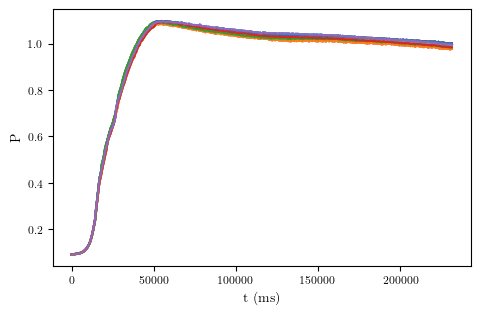

In [99]:
for i in range(N_exp):
    plt.plot(df2['Time [s]'],df2.iloc[:, -5:])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()


In [100]:
c=-1
P_exp=np.array(df2.iloc[:, -5:])[:c]
T_exp=np.array(df2['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(5, 230720.9)

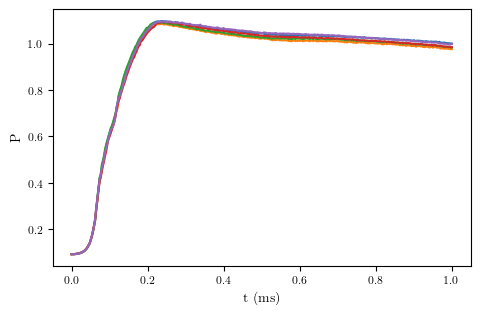

In [101]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [102]:
N_f = 100 # Number of residual point
N_d = 700 #Number of data

u_star = P_exp.T.flatten().reshape([-1,1])
X_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = X_star[::len(T_exp)]
uu1 = u_star[::len(T_exp)]

# Additional data
idx = np.random.choice(u_star.shape[0], N_d-len(uu1), replace=False)
xxd = X_star[idx]
uud = u_star[idx]

X_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
u_train = np.concatenate((uu1,uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
# X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
u_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32)

In [103]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        p=net(t, W_p, b_p)
        phi=net(tf.concat([p,t],1), W_phi, b_phi)
    p_t = tape1.gradient(p, t) 
    f = p_t - phi
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, u_star_tf, lambda_r, lambda_b, opt):
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_r, lambda_b])
        u_nn = net(t_u, W_p, b_p) 
        f_nn = net_f(t_f, W_p, b_p, W_phi, b_phi)
        loss_u = tf.square(lambda_b*(u_nn - u_train_tf))
        loss_f = tf.square(lambda_r*f_nn) 
        loss =  tf.reduce_mean(loss_u) + tf.reduce_mean(loss_f)
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
   
    return loss, tf.reduce_mean(loss_u), tf.reduce_mean(loss_f)



layers = [1, 50, 50, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 50, 50, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b = loss_weight(N_f, N_d)

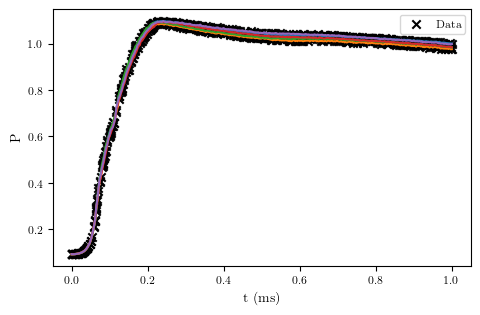

In [104]:
plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')

for i in range(N_exp):
    plt.plot(X_star[i*len(T_exp):(i+1)*len(T_exp)],u_star[i*len(T_exp):(i+1)*len(T_exp)])

# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [105]:
lr = 1e-4
# Nmax = 4*10**4
Nmax = 17000



optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_unk=[]
while n <= Nmax:
    loss_, loss_u, loss_f = train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf,u_star_tf,  lambda_r, lambda_b, optimizer)
    loss.append(loss_)
    loss_unk.append(loss_f)
    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u}")
        print(f"Physicial loss is: {loss_f}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 938098.0625
Data loss is: 938097.9375
Physicial loss is: 0.12019366025924683
Iteration is: 10
Total loss is: 907134.5
Data loss is: 907134.375
Physicial loss is: 0.1441916972398758
Iteration is: 20
Total loss is: 872366.9375
Data loss is: 872366.8125
Physicial loss is: 0.14463968575000763
Iteration is: 30
Total loss is: 833569.4375
Data loss is: 833569.375
Physicial loss is: 0.0919223204255104
Iteration is: 40
Total loss is: 790616.5625
Data loss is: 790616.5
Physicial loss is: 0.03480767831206322
Iteration is: 50
Total loss is: 744193.8125
Data loss is: 744193.8125
Physicial loss is: 0.010387811809778214
Iteration is: 60
Total loss is: 694260.3125
Data loss is: 694260.3125
Physicial loss is: 0.004207922611385584
Iteration is: 70
Total loss is: 640961.375
Data loss is: 640961.375
Physicial loss is: 0.003276804694905877
Iteration is: 80
Total loss is: 584759.9375
Data loss is: 584759.9375
Physicial loss is: 0.003836055053398013
Iteration is: 90
Total loss 

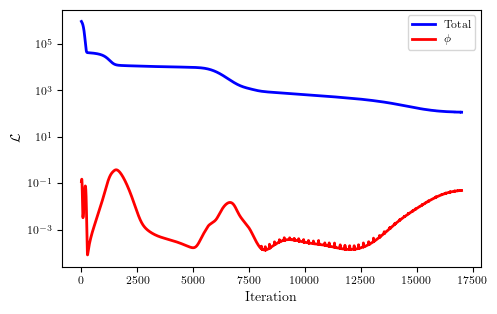

In [106]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,int(Nmax))]
loss_phi_list = [loss_unk[i].numpy() for i in range(0,int(Nmax))]

plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi$')       

plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [107]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net(x_star, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)

## Evaluating unknown function
u_pred_tf = tf.convert_to_tensor(u_pred, dtype=tf.float32) 
phi_pred = predict(tf.concat([u_pred_tf,X_star[:len(T_exp)]],1), W_phi, b_phi)

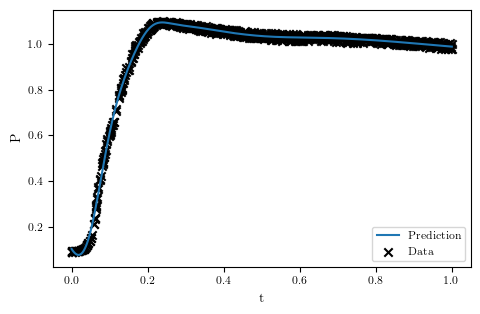

In [108]:
plt.plot(X_star[:len(T_exp)], u_pred, label='Prediction')
# for i in range(N_exp):
#     plt.plot(X_star[i*len(T_exp):(i+1)*len(T_exp)],u_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t')
plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

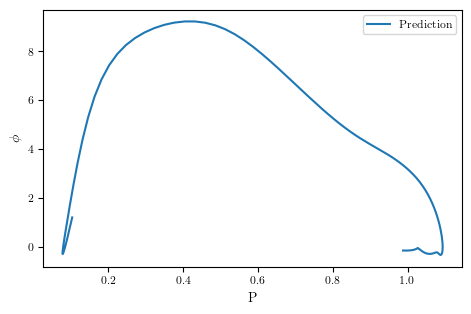

In [109]:
plt.plot(u_pred, phi_pred, label='Prediction')
# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi$')
# plt.savefig('figures/phi.pdf')
plt.show()

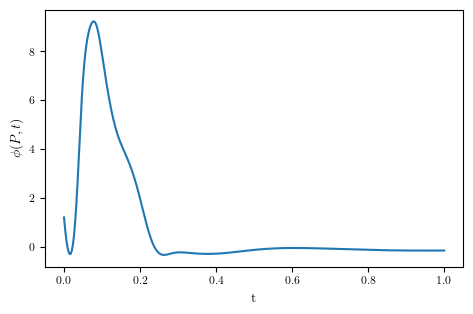

In [110]:
plt.plot(X_star[:len(T_exp)], phi_pred, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('$\phi (P,t)$')
plt.show()

In [123]:
Nt=20000
T_symb=np.zeros(Nt)
P_int=np.zeros(Nt)
dt=0.0001

T_symb[0]=0
P_int[0]=np.mean(uu1) #Initial conditions

for i in range(1,Nt):

    X_p=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_int[i]=P_int[i-1]+predict(X_p , W_phi, b_phi)*dt
    T_symb[i]=T_symb[i-1]+dt

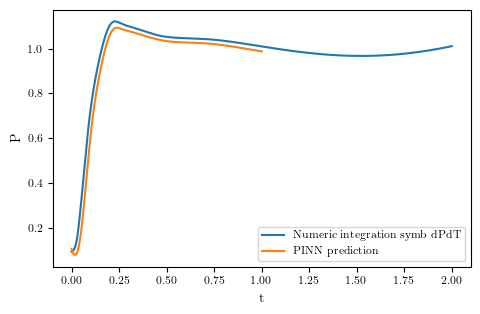

In [124]:
plt.plot(T_symb, P_int, label='Numeric integration symb dPdT')

plt.plot(X_star[:len(T_exp)], u_pred, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

Si N_max es muy alto, hay overfitting y la reconstrucción no es buena. Las pinns aprenden primero las frecuencas más pequeñas, es decir los rasgos más genersles. Esto, para físicos amantes de las vacas redondas nos viene excelentemente bien. Por tanto, buscaremos el punto donde haya aprendido el caso más general con éxito

In [125]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=1000,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=[ "exp",  "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],

    # extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2"
)
# Fit phi
model_phi.fit(tf.concat([u_pred_tf,X_star[:len(T_exp)]],1), np.array(phi_pred))
print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.320e+05
Head worker occupation: 36.5%
Progress: 552 / 15000 total iterations (3.680%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           5.613e+00  1.594e+01  y = 0.8934
3           5.613e+00  -0.000e+00  y = -0.9452 * -0.9452
5           3.547e+00  2.296e-01  y = (-5.801 * x₀) + 6.3386
7           1.261e+00  5.171e-01  y = (29.637 + (-28.565 * x₀)) * x₀
9           9.917e-01  1.201e-01  y = ((91.038 + (-93.785 * x₀)) * x₁) + 2.8727
11          4.783e-01  3.645e-01  y = x₀ * ((30.973 + (-27.956 * x₀)) + (-3.5742 * x₁))
13          4.288e-01  5.466e-02  y = (x₁ * -6.7879) + (((x₀ * -23.87) + 27.04) * (x₀ + x₁))
15          4.195e-01  1.094e-02  y = (((x₀ * -22.671) + 25.894) * (x₀ + x₁)) + ((x₀ * -6.8761) ...
                                  * x₁)
17          3.784e-01  5.162e-02  y = (((x₀ + x₁) + x₁) * ((x₀ * -22.156) + 26.62)) + ((

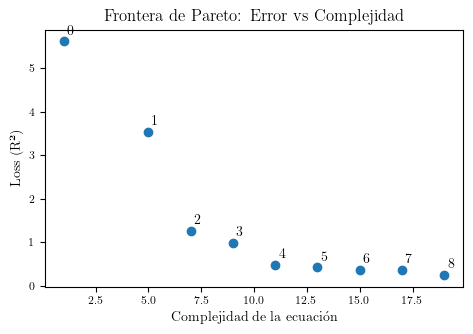

In [126]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

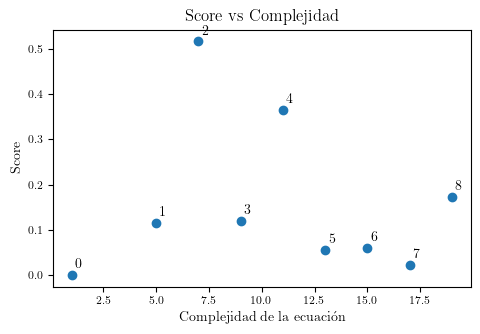

In [127]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [128]:
import sympy 
chose=4
expr=model_phi.sympy(chose)
sympy.together(expr)

x0*(x0*(-3.6105926*x1 - 27.467777) + 30.538212)

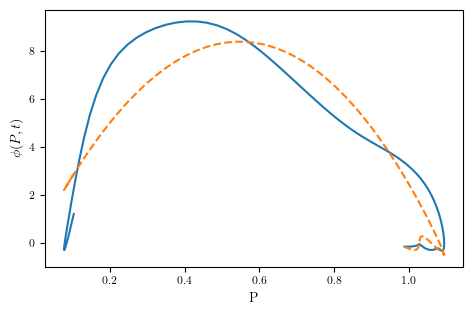

In [129]:
symb1=model_phi.predict(tf.concat([u_pred_tf,X_star[:len(T_exp)]],1),chose)
plt.plot(u_pred, phi_pred, label='PINN prediction')
plt.plot(u_pred, symb1, linestyle='--', label='Symbolic regresion')

plt.xlabel('P')
plt.ylabel('$\phi (P,t)$')
plt.show()

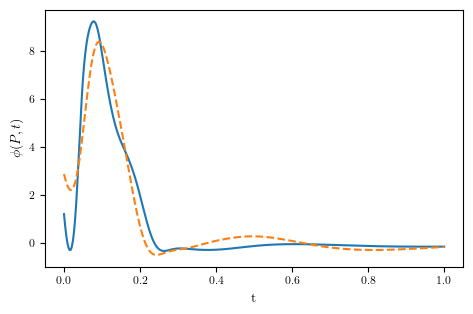

In [130]:
plt.plot(X_star[:len(T_exp)], phi_pred, label='PINN prediction')
plt.plot(X_star[:len(T_exp)], symb1, linestyle='--', label='Symbolic regresion')

plt.xlabel('t')
plt.ylabel('$\phi (P,t)$')
plt.show()

In [131]:
Nt=10000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb[0]=np.mean(uu1) #Initial conditions
T_symb[0]=0
for i in range(1,Nt):
    # P_symb[i]=P_symb[i-1]+(1/(T_symb[i-1]*(P_symb[i-1]-0.598)+0.068)+1.607/(P_symb[i-1]*(P_symb[i-1]-1.314)))*dt
    P_symb[i]=P_symb[i-1]+model_phi.predict(tf.concat([np.reshape(P_symb[i-1],[-1,1]),np.reshape(T_symb[i-1],[-1,1])],1),chose)*dt
    T_symb[i]=T_symb[i-1]+dt

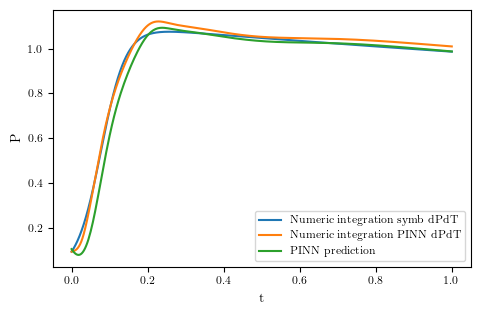

In [133]:
plt.plot(T_symb, P_symb, label='Numeric integration symb dPdT')
plt.plot(T_symb, P_int[:len(T_symb)], label='Numeric integration PINN dPdT')
plt.plot(X_star[:len(T_exp)], u_pred, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()